# Face Generation

이번 Udacity 프로젝트에서는 CelebA라는 데이터셋을 사용하여 (최대한 현실적으로 보이는) 새로운 얼굴 이미지를 생성하는 Deep Convolutional GAN을 만들것이다

### Pre-processed Data

* 리얼 원본 데이터셋 : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
* Pre-processed 데이터셋 다운로드 : https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip

진짜 CelebA 데이터셋은 대략 20만장의 얼굴 사진, 40개의 Binary Annotation이 딸려있는 데이터셋이다. 하지만 우리는 '그냥' 얼굴 사진만 필요하므로 Pre-process된 데이터를 사용한다

<br/>

$\rightarrow$ 64x64x3 사이즈로 얼굴부분만 크롭된 Numpy 이미지

In [39]:
# zip파일 압축해제 코드
# !unzip processed_celeba_small.zip

In [1]:
import os
import glob
print(f"현 디렉토리: {os.getcwd()}") 
print(f"현 디렉토리내 파일 및 폴더: {os.listdir()}")

현 디렉토리: C:\Users\USER\Desktop\Udacity\Genarate_Faces
현 디렉토리내 파일 및 폴더: ['.ipynb_checkpoints', 'data', 'Generate_Faces.ipynb', 'problem_unittests.py', '__pycache__']


<span style="color:green">[+]</span> 데이터 경로가 다소 이상하게 되어있다. / 그냥 짝대기와 언더바에 주의

`data`폴더 $\rightarrow$ `processed-celeba-small`폴더 $\rightarrow$ `processed_celeba_small`폴더 $\rightarrow$ `celeba`폴더

In [2]:
# 데이터 경로 예시 (10개)
glob.glob('data/processed-celeba-small/processed_celeba_small/celeba/*')[:10]

['data/processed-celeba-small/processed_celeba_small/celeba\\161979.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161980.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161981.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161982.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161983.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161984.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161985.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161986.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161987.jpg',
 'data/processed-celeba-small/processed_celeba_small/celeba\\161988.jpg']

In [3]:
print(f"데이터 개수: {len(glob.glob('data/processed-celeba-small/processed_celeba_small/celeba/*'))}개")

데이터 개수: 32601개


<br/>

---

<br/>


## 00. Settings

In [1]:
data_dir = './data/processed-celeba-small/processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests    # Udacity 제공 .py 파일

%matplotlib inline

<br/>

---

<br/>


## 01. Visualize the CelebA Data

CelebA 데이터셋은 원래 20만장의 얼굴이미지이나 64x64x3(RGB) 사이즈로 전처리해둠

**Exercise** : `get_dataloader` function을 만들자

1. `image_size` x `image_size` 의 Tensor return
2. shuffle and batch 

In [2]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

### 1-1. get_dataloader function

In [3]:
def get_dataloader(batch_size, image_size, data_dir='./data/processed-celeba-small/processed_celeba_small/'):

    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    image_dataset = datasets.ImageFolder(data_dir, transform)
    return torch.utils.data.DataLoader(image_dataset, 
                                        batch_size = batch_size,
                                        shuffle = True)

### 1-2. Create a DataLoader

In [4]:
batch_size = 128
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size)

### 1-3. Visualize data

In [5]:
import PIL
from PIL import Image

In [6]:
images, _ = next(iter(celeba_train_loader))
print(f"1 batch의 데이터 차원: {images.size()}")

1 batch의 데이터 차원: torch.Size([128, 3, 32, 32])


In [7]:
# 1 batch의 128개의 이미지 중 1개만 PIL이미지로 변환
to_pil = torchvision.transforms.ToPILImage()
images_PIL = to_pil(images[2])

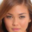

In [8]:
images_PIL

<br/>

---

<br/>


## 02. More Pre-process

Generator의 output은 `tanh`, 즉 Hyperbolic Tangent function으로 activation되므로 pixel value의 범위를 -1부터 1까지로 조정해줄 필요가 있다

In [9]:
# 원래 Tensor 이미지 pixel값의 범위는 0~1
print(f"원래 이미지의 pixel 최소값: {images[8].min()}")
print(f"원래 이미지의 pixel 최대값: {images[8].max()}")

원래 이미지의 pixel 최소값: 0.0117647061124444
원래 이미지의 pixel 최대값: 0.9019607901573181


### 2-1. scale function

In [10]:
def scale(x, feature_range=(-1,1)):
    min, max = feature_range
    return x * (max - min) + min

### 2-2. Check scaled range

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[8]
scaled_img = scale(img)

print(f"Scale된 이미지의 pixel 최소값: {scaled_img.min()}")
print(f"Scale된 이미지의 pixel 최대값: {scaled_img.max()}")

Scale된 이미지의 pixel 최소값: -0.9764705896377563
Scale된 이미지의 pixel 최대값: 0.8039215803146362


<br/>

---

<br/>

## 03. Define the Model

GAN은 Discriminator와 Generator가 경쟁하는 구조로 구성되어 있다

### 3-1. Discriminator

Discriminator는 단순하게 Convolutional Classifier이다. without maxpooling layer, 또한 복잡한 데이터를 처리하기 위하여 깊은, 즉 Deep network를 구성해야되는데 이때 Normalization이 필요하게 된다

1. Discriminator의 입력은 `32x32x3` size의 tensor 이미지
2. Discriminator의 출력은 single value, 입력 이미지가 Real or Fake인지를 나타내는

In [12]:
import torch.nn as nn
import torch.nn.functional as F

### 3-2. conv function

Discriminator를 정의할때 사용하면 편한 `conv` helper function을 만들자

batch_normalization layer를 만들기 쉽게 하는 것으로

단순히 `conv` function에 아래의 parameter들을 넣어주면 conv + batch_norm layer를 return

* `in_channels` : 입력 데이터의 depth
* `out_channels` : 출력 데이터의 depth
* `kernel_size` : Kernel or Filter size
* `stride` : stride
* `padding` : padding
* `batch_norm` : Batch Normalization layer 생성 여부 boolean값


In [13]:
def conv(in_channels,
         out_channels,
         kernel_size,
         stride=2,
         padding=1,
         batch_norm=True):
    
    layers = []
    conv_layer = nn.Conv2d(in_channels = in_channels,
                           out_channels = out_channels,
                           kernel_size = kernel_size,
                           stride = stride,
                           padding = padding,
                           bias = False)
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

### 3-3. Define Discriminator

* Filter size : 4
* Stride : 2
* Padding : 1
* Input image size : 32x32x3
* <span style="color:red">[!]</span> 첫번째 conv layer는 batch norm layer 없이

---

데이터 차원(size) 변화

$$
S_{output} = \frac{ S_{input} + 2 \times padding - S_{filter}}{Stride} + 1
$$

$$
S_{output} = \frac{ S_{input} + 2 \times 1 - 4}{2} + 1 = \frac{S_{input}}{2}
$$

`32x32x3` $\rightarrow$ `16x16xconv_dim` $\rightarrow$ `8x8xconv_dim*2` $\rightarrow$ `4x4xconv_dim*4` $\rightarrow$ `2x2xconv_dim*8` $\rightarrow$ `1`

if `conv_dim` = 64,

`3072` $\rightarrow$ `16384` $\rightarrow$ `8192` $\rightarrow$ `4096` $\rightarrow$ `2048` $\rightarrow$ `1`


In [14]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim):
        """
        param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, 4, batch_norm = False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        
        self.fc = nn.Linear(2*2*conv_dim*8, 1)
        
    def forward(self, x):
        """
        param x: The input to the neural network(discriminator)
        """
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        # Flatten
        x = x.view(-1, self.conv_dim*8*2*2) 
        out = self.fc(x)
        
        return out
        
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


### 3-4. Generator

Generator는 <span style="color:yellowgreen">Latent vector</span>, 즉 랜덤노이즈 벡터를 받아서 이를 upsample하여 우리의 데이터셋의 이미지 사이즈인 `32x32x3`와 같은 사이즈의 생성이미지를 출력하여야 한다. 

따라서 <span style="color:orange">Transpose Convolutional Layer</span> with normalization 이용

1. Generator의 입력은 `z_size`의 크기를 가진 Latent vector
2. Generator의 출력은 `32x32x3`

### 3-5. deconv function

Generator를  정의할때 사용하면 편한 `deconv` helper function을 만들자

batch_normalization layer를 만들기 쉽게 하는 것으로

단순히 `deconv` function에 아래의 parameter들을 넣어주면 deconv + batch_norm layer를 return

* `in_channels` : 입력 데이터의 depth
* `out_channels` : 출력 데이터의 depth
* `kernel_size` : Kernel or Filter size
* `stride` : stride
* `padding` : padding
* `batch_norm` : Batch Normalization layer 생성 여부 boolean값


In [15]:
def deconv(in_channels,
           out_channels,
           kernel_size,
           stride=2,
           padding=1,
           batch_norm=True):
    
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels,
                                              out_channels,
                                              kernel_size,
                                              stride,
                                              padding,
                                              bias=False)
    
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

### 3-6. Define Generator

* Filter size : 4
* Stride : 2
* Padding : 1
* Input latent vector size : `z_size` = 100
* <span style="color:red">[!]</span> 마지막 deconv layer는 batch norm layer 없이

---

데이터 차원(size) 변화

$$
S_{output} = Stride \times (S_{input}-1) - 2 \times padding + S_{filter}
$$

$$
S_{output} = 2 \times (S_{input}-1) - 2 \times 1 + 4 = 2 \times S_{input}
$$

`100` $\rightarrow$ `2x2xconv_dim*8` $\rightarrow$ `4x4xconv_dim*4` $\rightarrow$ `8x8xconv_dim*2` $\rightarrow$ `16x16xconv_dim` $\rightarrow$ `32x32x3`

if `conv_dim` = 64,

`100` $\rightarrow$ `2048` $\rightarrow$ `4096` $\rightarrow$ `8192` $\rightarrow$ `16384` $\rightarrow$ `3072`

In [16]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        param z_size: The length of the input latent vector, z
        param conv_dim : The depth of the inputs to the *last* transpose convolutional layer 
        """
        super(Generator, self).__init__()
        #self.z_size = z_size
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, 2*2*conv_dim*8)
        
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm = False)
        
    def forward(self, x):
        """
        param x: The input to the neural network(Generator)
        return: 32x32x3 Tensor image
        """
        
        x = self.fc(x)
        
        # Reshape to (batch_size, depth, height, width)
        # Reshape to (128, conv_dim*8, 2, 2)
        x = x.view(-1, self.conv_dim*8, 2, 2)  
        
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        
        # Last layer -> tanh activation / not relu
        x = self.deconv4(x)
        out = torch.tanh(x)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


<br/>

---

<br/>

## 04. Initialize the weights of networks

### + How to access network's weight
network(Discriminator, Generator)의 weight를 조금 더 빨리 수렴할 수 있게끔 임의의 값들로 초기화(initialize)하고자 한다 <span style="color:red">(중앙, 즉 평균이 0이고, 표준편차가 0.02인 정규분포화)</span>

$\rightarrow$ All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02
* THe bias terms, if they exist, may be left alone or set to 0.



### 4-1. weights_init_normal function

In [17]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02
    param m: A module or layer in a network
    """
    classname = m.__class__.__name__
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        m.weight.data.normal_(0.0, 0.02)
        
        # The bias terms, if they exist, set to 0
        if hasattr(m, 'bias') and m.bias is not None:
            m.bias.data.zero_()

---

### 4-2. weight_init_normal function test


<span style="color:blue">Example</span>


아래와 같이 정의된 module(model) `D`에

`D = Discriminator(conv_dim = 64)`

`D.__class__` : 해당 Instance의 부모 Class를 불러오고

`D.__class__.__name__`을 통해 부모 Class의 '이름'들을 불러올 수 있다. 그냥 실행 시`Discriminator`만 나오지만 `apply` function을 통하여 각 Layer들의 이름을 따올 수 있다

우리가 만들었던 Class인 `Discriminator`는 4개의 Convolutional, 3개의 BatchNorm, 1개의 Linear Layer들로 이루어져있었다

따라서 `D_test.__class__.__name__`을 하나의 변수로 할당해놓고

해당 변수에 `.find('Conv' or 'BatchNorm' or 'Linear')`등을 돌리면

각각 `'Conv', 'BatchNorm', 'Linear'`일때 -1이 아닌 값을 return하나보다

In [27]:
D_test = Discriminator(conv_dim = 64)

In [32]:
## Initiate 이전 weight값 / (0,0,0)부분만 인덱싱하여 보기!
# conv1 layer weight 
print(D_test._modules['conv1']._modules['0'].weight[0,0,0])

# fc layer weight
print(D_test._modules['fc'].weight)

tensor([ 0.0578,  0.0527,  0.0778, -0.0025], grad_fn=<SelectBackward0>)
Parameter containing:
tensor([[-0.0056, -0.0146, -0.0220,  ..., -0.0074,  0.0034, -0.0030]],
       requires_grad=True)


In [33]:
# weight initiation
D_test.apply(weights_init_normal)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [34]:
## Initiate 이후 weight값 / (0,0,0)부분만 인덱싱하여 보기!
# conv1 layer weight 
print(D_test._modules['conv1']._modules['0'].weight[0,0,0])

# fc layer weight
print(D_test._modules['fc'].weight)

tensor([ 0.0069, -0.0099, -0.0337, -0.0148], grad_fn=<SelectBackward0>)
Parameter containing:
tensor([[ 0.0377, -0.0392, -0.0008,  ..., -0.0120, -0.0164,  0.0213]],
       requires_grad=True)


<br/>

---

<br/>

## 05. Build complete network

network model의 hyperparameter를 설정하고

앞서 만든 Discriminator, Generator Class를 이용하여 network를 완성시켜보자

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [19]:
# Define model hyperparams
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fal

### + Traning on GPU

`train_on_gpu`라는 boolean 변수를 만들어서 

* model
* (model) input
* loss function argument

를 GPU로 이동시키는 것을 까먹지말자!

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

No GPU found. Please use a GPU to train your neural network.


<br/>

---

<br/>

## 06. Discriminator and Generator Losses

### 6-1. Discriminator Losses

* Discriminator의 Losses
  1. 진짜 이미지 판별 시의 Loss
  2. 가짜 이미지 판별 시의 Loss

---

### 6-2. Generator Loss

* Generator의 Loss
  * Discriminator에 Generator가 생성한 이미지(가짜)를 주면서, 너는 지금 진짜 이미지를 판별하는거야 라고 했을 때의 Loss $\rightarrow$ <span style="color:orange">flipped label</span>

#### Exercise: Complete real and fake loss functions!

You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions

### 6-3. real_loss and fake_loss function

In [21]:
def real_loss(D_out):
    """
    Discriminator의 출력이 Real에 얼마나 가까운지 계산
    param D_out: Discriminator logits
    return: real loss값 
    """
    # Make label first!
    # 따라서 batch_size를 먼저 파악해야함
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size) * 0.9 # Label Smoothing
    if train_on_gpu:
        labels = labels.cuda()
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss


def fake_loss(D_out):
    """
    Discriminator의 출력이 Fake에 얼마나 가까운지 계산
    param D_out: Discriminator logits
    return: fake loss값
    """
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

<br/>

---

<br/>

## 07. Optimizers

Discriminator(D)와 Generator(G)를 위한 optimizer를 정의하자

In [22]:
import torch.optim as optim

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

<br/>

---

<br/>

## 08. Training

<span style="color:green">**[+]**</span> Saving Samples

`fixed_z`, 즉 고정된 Latent vector를 통해서 훈련이 진행되는 동안 Generator의 발전 경과를 지켜보기 위하여 Sample을 만들고 저장하자


<span style="color:green">**[+]**</span> Move to GPU (model, inputs)

### 8-1. train function

In [25]:
from time import time

In [26]:
def train(D, G, n_epochs, print_every=50):
    """
    param D: the discriminator network
    param G: the generator network
    param n_epochs: the number of epochs to train for
    param print_every: when to print and record the model's losses
    return: D and G losses
    """
    
    # Move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()
        
    # Loss와 Sample을 keep tracking할 리스트
    samples = []
    losses = []
    
    # Sample생성을 위한 fixed data (constant throughout training)
    sample_size = 16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))   # -1~1값
    fixed_z = torch.from_numpy(fixed_z).float()
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
        
    ###################################################################
    
    # epoch training loop
    for epoch in range(n_epochs):
        start = time()
        
        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):
            
            batch_size = real_images.size(0)
            # Scale the input data(Real images)
            real_images = scale(real_images)
            
            #######################
            # TRAIN DISCRIMINATOR #
            #######################
            d_optimizer.zero_grad()

                
            # 1. Real loss
            if train_on_gpu:
                real_images = real_images.cuda()
            
            D_real = D(real_images)         # Discriminator <- Real images
            d_real_loss = real_loss(D_real) # Discriminator Real loss
            
            
            # 2. Fake loss
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))  
            z = torch.from_numpy(z).float() # Latent Vector 생성
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)              # Fake image 생성
            
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # 3. Loss sum and Backpropagation
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            ###################
            # TRAIN GENERATOR #
            ###################
            g_optimizer.zero_grad()
            
            z = np.random.uniform(-1, 1, size = (batch_size, z_size))
            z = torch.from_numpy(z).float()  # Latent Vector 생성
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)               # Fake image 생성
            
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)       # Flipped label
            
            
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH## 
        end = time()
        print(f"Epoch spending time: {end-start}[sec]")
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses
            

---

### 8-2. Let's Train!

In [27]:
n_epochs = 5

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/    5] | d_loss: 0.6976 | g_loss: 2.3783
Epoch [    1/    5] | d_loss: 0.8793 | g_loss: 1.4895
Epoch [    1/    5] | d_loss: 0.7453 | g_loss: 2.0885
Epoch [    1/    5] | d_loss: 0.9055 | g_loss: 1.4087
Epoch [    1/    5] | d_loss: 0.8046 | g_loss: 2.2764
Epoch [    1/    5] | d_loss: 0.7955 | g_loss: 2.1212
Epoch [    1/    5] | d_loss: 0.8742 | g_loss: 2.7672
Epoch [    1/    5] | d_loss: 0.7508 | g_loss: 1.7580
Epoch [    1/    5] | d_loss: 0.8972 | g_loss: 1.7392
Epoch [    1/    5] | d_loss: 1.2865 | g_loss: 3.4747
Epoch [    1/    5] | d_loss: 1.0844 | g_loss: 1.0743
Epoch [    1/    5] | d_loss: 0.9307 | g_loss: 2.6171
Epoch [    1/    5] | d_loss: 0.9831 | g_loss: 1.3340
Epoch [    1/    5] | d_loss: 0.9195 | g_loss: 1.3072
Epoch [    1/    5] | d_loss: 0.8479 | g_loss: 2.4017
Epoch spending time: 1094.4432027339935[sec]
Epoch [    2/    5] | d_loss: 0.9538 | g_loss: 2.2382
Epoch [    2/    5] | d_loss: 0.7901 | g_loss: 2.7951
Epoch [    2/    5] | d_loss: 0.9681 

<br/>

---

<br/>

## 09. Training Loss

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

<br/>

---

<br/>

## 10. Generator samples from training

In [1]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [2]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

NameError: name 'pkl' is not defined

In [ ]:
_ = view_samples(-1, samples)

<br/>

---

<br/>

### Question: What do you notice about your generated samples and how might you improve this model?

When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
